In [459]:
import psycopg2
import numpy as np
import pandas as pd

In [461]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

In [463]:
host="192.168.2.23"
port=5432
user="amt"
dbname="qdap_test"

In [465]:
def make_connection_to_db(host, port, user, dbname):
    conn = psycopg2.connect(host= host, port=port, user=user, dbname=dbname)
    cursor = conn.cursor()
    return cursor, conn

In [1513]:
def fetch_options_data(cursor, symbol, strike_price, date, month, year, type):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{option}' 
            AND strike = {strike_price} 
            AND extract(year from oopm.expiry) = {year} 
            AND extract(month from oopm.expiry) = {month}
            AND extract(day from oopm.expiry) = {date}
            AND opt_type = '{type}'
            ORDER BY date_timestamp ASC;
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

def fetch_options_data(cursor, symbol, expiry):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{symbol}' 
            AND expiry_type = 'I'
            AND expiry = (
                SELECT MAX(oopmm.expiry)
                FROM ohlcv_options_per_minute oopmm
                WHERE oopmm.symbol = '{symbol}'
                AND oopmm.expiry_type = 'I'
                AND oopmm.expiry <= '{expiry}'
            )
            ORDER BY date_timestamp ASC;
            
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [1515]:
def fetch_futures_data(cursor, symbol, x=0):
    query = f'''
        SELECT *
        FROM ohlcv_future_per_minute ofpm
        WHERE ofpm.symbol = '{symbol}'
        AND ofpm.expiry_type = 'I'
        AND ofpm.expiry = (
            SELECT ofpmm.expiry 
            FROM ohlcv_future_per_minute ofpmm
            WHERE ofpmm.symbol = '{symbol}'
            AND ofpmm.expiry_type = 'I'
            GROUP BY ofpmm.expiry
            OFFSET {x}
            LIMIT 1
        )
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [1517]:
def fetch_equity_data(cursor, symbol, begin, expiry):
    query = f'''
        SELECT *
        FROM ohlcv_cm_per_minute ocpm
        WHERE ocpm.symbol = '{symbol}'
        AND date_timestamp <= '{expiry}'
        AND date_timestamp >= '{begin}'
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [473]:
def fetch(host, port, user, dbname, symbol, x=15):
    cursor, conn = make_connection_to_db(host, port, user, dbname)
    # hardcoded for near month expiry
    df_futures = fetch_futures_data(cursor, symbol, x) # date is the expiry
    expiry = df_futures['expiry'].iloc[0]
    df_options = fetch_options_data(cursor, symbol, expiry)
    cursor.close()
    conn.close()
    return df_futures, df_options

In [1747]:
symbol = "BANKNIFTY"
x = 20 # index of the array of all the unique expiries of I futures. 
moneyness_strike = 0
fund_locked = 1000 # inr

In [1749]:
fund_locked *= 100

In [1244]:
DF_FUTURES, DF_OPTIONS = fetch(host, port, user, dbname, symbol, x)

In [1245]:
# ====================================================================================================================================== #

In [1751]:
df_futures = DF_FUTURES.copy()
df_options = DF_OPTIONS.copy()

In [1753]:
df_futures = df_futures.drop_duplicates(subset='date_timestamp', keep='first')
df_options = df_options.drop_duplicates(subset=['date_timestamp', 'strike', 'opt_type'], keep='first')

In [1754]:
df_calls = df_options[(df_options['opt_type'] == 'CE')]
df_puts  = df_options[(df_options['opt_type'] == 'PE')]

In [1755]:
df_futures.set_index('date_timestamp', inplace=True)
df_calls.set_index('date_timestamp', inplace=True)
df_puts.set_index('date_timestamp', inplace=True)

In [1756]:
timestamps = df_options['date_timestamp'].unique()

In [1757]:
# NOTE THAT OPTIONS AND FUTURES EXPIRY IN THE QDAP DATABASE ARE NOT FOLLOWING THE SAME FORMAT.
expiry_options = pd.Timestamp(df_options['expiry'].iloc[0]).date()
expiry_futures = pd.Timestamp(df_futures['expiry'].iloc[0]).date()
starts_options = pd.Timestamp(df_options.index[0]).date()
starts_futures = pd.Timestamp(df_futures.index[0]).date()

start_intersection = max(starts_options, starts_futures)
end_intersection = min(expiry_options, expiry_futures)
start_intersection = pd.Timestamp.combine(start_intersection, pd.Timestamp('09:15:00').time())
end_intersection = pd.Timestamp.combine(end_intersection, pd.Timestamp('15:29:00').time())

print("starts_options:", starts_options)
print("expiry_options:", expiry_options)
print("starts_futures:", starts_futures)
print("expiry_futures:", expiry_futures)
print("start_intersection:", start_intersection)
print("end_intersection:", end_intersection)

range_futures = (df_futures.index <= end_intersection) & (df_futures.index >= start_intersection)
range_options = (df_options['date_timestamp'] <= end_intersection) & (df_options['date_timestamp'] >= start_intersection)

df_futures = df_futures[range_futures]
df_options = df_options[range_options]
# df_futures = df_futures[range_futures]
# df_options = df_options[range_options]

starts_options: 1970-01-01
expiry_options: 2023-12-28
starts_futures: 2023-12-01
expiry_futures: 2023-12-28
start_intersection: 2023-12-01 09:15:00
end_intersection: 2023-12-28 15:29:00


In [1758]:
df_calls_close = df_calls.pivot(columns='strike', values='close').ffill()
df_puts_close = df_puts.pivot(columns='strike', values='close').ffill()

In [1759]:
df_calls_open = df_calls.pivot(columns='strike', values='open').ffill()
df_puts_open = df_puts.pivot(columns='strike', values='open').ffill()

In [1760]:
market_holidays = [
    (1, 26), (3, 8), (3, 29), (4, 19), (5, 1),
    (8, 15), (10, 2), (10, 24), (11, 12), (12, 25)
]

trading_days = pd.date_range(start=start_intersection, end=end_intersection, freq='B')
trading_days = trading_days[~trading_days.to_series().apply(lambda x: (x.month, x.day) in market_holidays)]

# Generate a complete range of trading minutes for each trading day
trading_minutes = pd.date_range(start='09:15:00', end='15:29:00', freq='min').time

# Create a complete index of trading timestamps
complete_index = pd.DatetimeIndex([pd.Timestamp.combine(day, time) for day in trading_days for time in trading_minutes])

In [1761]:
df_futures = df_futures.reindex(complete_index).ffill()
df_calls_close = df_calls_close.reindex(complete_index).ffill()
df_puts_close = df_puts_close.reindex(complete_index).ffill()
df_calls_open = df_calls_open.reindex(complete_index).ffill()
df_puts_open = df_puts_open.reindex(complete_index).ffill()

In [1762]:
df_call_put_open = [df_puts_open, df_calls_open]
df_call_put_close = [df_puts_close, df_calls_close]

In [1763]:
put_strikes = np.array(df_puts_close.columns, dtype=int)
call_strikes = np.array(df_calls_close.columns, dtype=int)

In [1764]:
print(df_calls_close.shape, df_calls_open.shape)
print(df_puts_close.shape, df_puts_open.shape)
print(df_futures.shape)

(7125, 119) (7125, 119)
(7125, 127) (7125, 127)
(7125, 9)


In [1765]:
def ema(window_short, window_long, df):
    df['short'] = df['close'].ewm(span=window_short).mean()
    df['long'] = df['close'].ewm(span=window_long).mean() 
    polarity = df['short'] - df['long']
    polarity = polarity > 0
    signals = []
    position_polarity_positive = polarity.iloc[window_long]
    for i in range(window_long, df.shape[0]):
        if(polarity.iloc[i] != position_polarity_positive):
            position_polarity_positive = polarity.iloc[i]
            signals.append((int(position_polarity_positive), df.index[i], df.index[i+1]))
            # bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
    return signals

In [1766]:
# bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
window_short = 9
window_long = 26
signals = ema(window_short, window_long, df_futures)
print(len(signals))
signals

282


[(0, Timestamp('2023-12-01 10:37:00'), Timestamp('2023-12-01 10:38:00')),
 (1, Timestamp('2023-12-01 10:39:00'), Timestamp('2023-12-01 10:40:00')),
 (0, Timestamp('2023-12-01 10:42:00'), Timestamp('2023-12-01 10:43:00')),
 (1, Timestamp('2023-12-01 11:04:00'), Timestamp('2023-12-01 11:05:00')),
 (0, Timestamp('2023-12-01 11:50:00'), Timestamp('2023-12-01 11:51:00')),
 (1, Timestamp('2023-12-01 12:00:00'), Timestamp('2023-12-01 12:01:00')),
 (0, Timestamp('2023-12-01 12:02:00'), Timestamp('2023-12-01 12:03:00')),
 (1, Timestamp('2023-12-01 12:38:00'), Timestamp('2023-12-01 12:39:00')),
 (0, Timestamp('2023-12-01 12:50:00'), Timestamp('2023-12-01 12:51:00')),
 (1, Timestamp('2023-12-01 13:17:00'), Timestamp('2023-12-01 13:18:00')),
 (0, Timestamp('2023-12-01 14:07:00'), Timestamp('2023-12-01 14:08:00')),
 (1, Timestamp('2023-12-01 14:24:00'), Timestamp('2023-12-01 14:25:00')),
 (0, Timestamp('2023-12-01 14:26:00'), Timestamp('2023-12-01 14:27:00')),
 (1, Timestamp('2023-12-01 15:16:00'),

In [1767]:
df_futures

,symbol,open,low,high,close,volume,expiry,expiry_type,id,short,long
2023-12-01 09:15:00,BANKNIFTY,4479145,4476270,4483685,4482335,48975,2023-12-28 14:30:00,I,13448954,4.482335e+06,4.482335e+06
2023-12-01 09:16:00,BANKNIFTY,4482165,4478740,4482625,4482285,29175,2023-12-28 14:30:00,I,60243858,4.482307e+06,4.482309e+06
2023-12-01 09:17:00,BANKNIFTY,4482795,4481350,4483715,4483200,27660,2023-12-28 14:30:00,I,13448956,4.482673e+06,4.482629e+06
2023-12-01 09:18:00,BANKNIFTY,4483240,4483240,4486500,4486500,23925,2023-12-28 14:30:00,I,60243860,4.483969e+06,4.483711e+06
2023-12-01 09:19:00,BANKNIFTY,4486430,4485600,4487500,4486620,15240,2023-12-28 14:30:00,I,13448958,4.484758e+06,4.484386e+06
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,BANKNIFTY,4850775,4850370,4851095,4850655,8535,2023-12-28 14:30:00,I,62096267,4.850869e+06,4.850641e+06
2023-12-28 15:26:00,BANKNIFTY,4850655,4850530,4851405,4851100,5400,2023-12-28 14:30:00,I,15301365,4.850915e+06,4.850675e+06
2023-12-28 15:27:00,BANKNIFTY,4851100,4850700,4851300,4851015,2130,2023-12-28 14:30:00,I,62096269,4.850935e+06,4.850700e+06
2023-12-28 15:28:00,BANKNIFTY,4851005,4851005,4851645,4851625,8220,2023-12-28 14:30:00,I,15301367,4.851073e+06,4.850769e+06


In [1768]:
def find_closest_strike(strikes, value):
    strikes = np.array(strikes.index)
    strikes.sort()
    closest_strike_index = np.argmin(np.abs(strikes - int(value)))
    closest_strike = strikes[closest_strike_index]
    return closest_strike, closest_strike_index

In [1770]:
def choose_strike_of_moneyness(opt_type, index_strike, futures_price, df_target, strikes):
    # decision logic
    call_put = (1)*(opt_type) + (-1)*(1-opt_type)
    moneyness = (1)*(index_strike >= 0) + (-1)*(index_strike < 0)
    decision = call_put * moneyness
    # ITM calls (+1 * +1) and OTM puts (-1 * -1) will have a strike < futures_price
    # OTM calls (-1 * +1) and ITM puts (+1 * -1) will have a strike > futures_price
    num_strikes = len(strikes)
    closest_strike, index = find_closest_strike(df_target, futures_price)
    if decision == 1:
        if index >= index_strike:
            strike = strikes[index-index_strike]
        else:
            eligible_candidates = strikes[:index]
            strike = -1
    else:
        if index + index_strike < num_strikes:
            strike = strikes[index+index_strike]
        else:
            eligible_candidates = strikes[index:]
            strike = -1
    if strike == -1:
        moneyness = "ATM" if index_strike == 0 else ["OTM", "ITM"][index_strike >= 0]
        print(f"{["BEARISH", "BULLISH"][opt_type]} SIGNAL WASTED: Couln't find an {moneyness}-{abs(index_strike)} {["PUT", "CALL"][opt_type]} option trade in the database at {df_target.index[0]}.")
        print(f">>> Futures price: {futures_price}.")
        print(f">>> Eligible strikes traded on/or before the current timestamp: {[i for i in eligible_candidates]}")
        print()
    return strike

In [1771]:
# format of trades
# (number, 1/0, 1/0, t, s)
# (price, call/put, long/short, timestamp, strike)
# format of trades
# (number, 1/0, 1/0, t, s)
# (price, call/put, long/short, timestamp, strike)
def make_trades(signals, moneyness_strike, expiry, df_futures, df_calls_puts_open, fund_locked, strikes):
    available_funds = fund_locked
    trades = []
    ix = 0
    # brute forcing the first trade (fund locking)
    while ix < len(signals):
        # first signal details
        first_signal_type = signals[ix][0]
        first_valid_tradable_timestamp = signals[ix][2]
        futures_price = df_futures['open'].loc[first_valid_tradable_timestamp]

        # calculation and logic
        opt_type = ["PE", "CE"][first_signal_type]
        df_target = df_calls_puts_open[first_signal_type].loc[first_valid_tradable_timestamp]
        strike = choose_strike_of_moneyness(first_signal_type, moneyness_strike, futures_price, df_target, strikes[first_signal_type])
        if strike == -1:
            ix += 1
            continue
        price = df_calls_puts_open[first_signal_type][strike].loc[first_valid_tradable_timestamp]
        # validity of positions (fund locking)
        if price <= available_funds:
            trades.append((price, first_signal_type, 1, first_valid_tradable_timestamp, strike))
            available_funds -= price
            break
        ix += 1

    # executing trades as per the signals generated
    for i, signal in enumerate(signals[ix + 1:]):
        # last trade details
        last_trade = trades[len(trades) - 1]
        last_trade_price = last_trade[0]
        last_trade_opt_type = last_trade[1]
        last_trade_position = last_trade[2]
        last_strike = last_trade[4]

        # current signal details
        signal_nature = signal[0]
        signal_time_stamp = signal[1]
        valid_tradable_time_stamp = signal[2]

        # calculation and logic
        square_off_price = df_calls_puts_open[last_trade_opt_type][last_strike].loc[valid_tradable_time_stamp]
        futures_price = df_futures['open'].loc[valid_tradable_time_stamp]
        opt_type = ["PE", "CE"][signal_nature]  # df of calls/puts (rows-> timestamps, cols-> strikes, values-> close)
        df_target = df_calls_puts_open[signal_nature].loc[valid_tradable_time_stamp]
        current_strike = choose_strike_of_moneyness(signal_nature, moneyness_strike, futures_price, df_target, strikes[signal_nature])
        if current_strike == -1:
            continue
        buying_price = df_calls_puts_open[signal_nature][current_strike].loc[valid_tradable_time_stamp]

        # validity of positions (fund locking)
        if last_trade_position == 1:
            trades.append((square_off_price, last_trade_opt_type, 0, valid_tradable_time_stamp, last_strike))
            available_funds += min(square_off_price, last_trade_price)
        if buying_price <= available_funds:
            trades.append((buying_price, signal_nature, 1, valid_tradable_time_stamp, current_strike))
            available_funds -= buying_price

    # manually squaring off the last trade at the last tradable minute
    last_trade = trades[len(trades) - 1]
    last_trade_opt_type = last_trade[1]
    last_trade_strike = last_trade[4]
    expiry = pd.to_datetime(expiry, format='%d-%m-%Y')
    last_valid_tradable_time_stamp = pd.Timestamp(f"{expiry} 15:29:00")
    last_square_off_price = df_calls_puts_open[last_trade_opt_type][last_trade_strike].loc[last_valid_tradable_time_stamp]
    trades.append((last_square_off_price, last_trade_opt_type, 0, last_valid_tradable_time_stamp, last_trade_strike))
    return trades

In [1772]:
def stats_per_trade(open, close, timestamps, df_ram, fund_blocked, risk_free=12):
    opt_type = open['Call/Put']
    strike = open['strike_price']

    open_time = open.name
    close_time = close.name
    # time_stamps = df_options.loc[open_time:close_time].index
    holding_period = (close_time - open_time).total_seconds() / 60

    open_price = open['Price']
    close_price = close['Price']
    profit = close_price - open_price

    dd = 0
    max_dd = 0
    last_max_price = close_price
    closes = df_ram[int(opt_type)][int(strike)]
    variations = []
    for timestamp in timestamps:
        last_max_price = max(last_max_price, closes[timestamp])
        dd = min(dd, closes[timestamp] - last_max_price)
        max_dd = min(dd, max_dd)
        variations.append(closes[timestamp] - close_price)

    variations = pd.Series(variations)
    std_granularity = variations.std()
    if std_granularity == 0:
        std_granularity = 1
    sharpe = profit - risk_free * 1 / 365 * 1 / 24 * 1 / 60 * 1 / 100 * fund_blocked * holding_period
    sharpe /= std_granularity
    return max_dd, profit, holding_period, std_granularity, sharpe
    

In [1773]:
def print_trades(df_trades, timestamps, df_ram, fund_blocked):
    open_position = None
    open_details = []
    close_details = []
    sharpes = []
    for i, row in df_trades.iterrows():
        pos = "Sell"
        open_position = False
        close_details = row
        if row["Position"]:
            pos = "Buy "
            open_position = True
            open_details = row
        type = "Put"
        if row["Call/Put"]:
            type = "Call"
        strike = row["strike_price"]
        price = row["Price"]
        print(f"at time: {i} || {pos} {type} option of strike = {strike} for a price of {price}")
        if not open_position:
            print("==> TRADE STATS")
            max_dd, profit, holding_period, std, sharpe = stats_per_trade(open_details, close_details, timestamps, df_ram, fund_blocked)
            sharpes.append(sharpe)
            print(">>>> maximum drawdown:", max_dd)
            print(">>>> profit:", profit)
            print(">>>> holding period:", holding_period, "minutes")
            print(">>>> standard deviation:", std)
            print(">>>> sharpe:", sharpe)
            print("=========================================================================================================")
    sharpes = pd.Series(sharpes)
    print(sharpes.mean())

In [1774]:
strikes = [put_strikes, call_strikes]
trades = make_trades(signals, moneyness_strike, end_intersection, df_futures, df_open, fund_locked, strikes)
df_trades = pd.DataFrame(trades, columns=['Price', 'Call/Put', 'Position', 'date_timestamp', 'strike_price'])
df_trades = df_trades.set_index('date_timestamp')

In [1778]:
df_trades

,Price,Call/Put,Position,strike_price
date_timestamp,,,,
2023-12-01 10:38:00,58740.0,0,1,4510000
2023-12-01 10:40:00,58180.0,0,0,4510000
2023-12-01 10:40:00,62790.0,1,1,4510000
2023-12-01 10:43:00,61080.0,1,0,4510000
2023-12-01 10:43:00,59150.0,0,1,4510000
...,...,...,...,...
2023-12-28 12:58:00,6715.0,1,1,4860000
2023-12-28 13:00:00,5790.0,1,0,4860000
2023-12-28 14:04:00,5245.0,1,1,4860000


In [1779]:
print_trades(df_trades, timestamps, df_open, fund_locked)

at time: 2023-12-01 10:38:00 || Buy  Put option of strike = 4510000.0 for a price of 58740.0
at time: 2023-12-01 10:40:00 || Sell Put option of strike = 4510000.0 for a price of 58180.0
==> TRADE STATS
>>>> maximum drawdown: -75495.0
>>>> profit: -560.0
>>>> holding period: 2.0 minutes
>>>> standard deviation: 13466.582932399373
>>>> sharpe: -0.04158780775433668
at time: 2023-12-01 10:40:00 || Buy  Call option of strike = 4510000.0 for a price of 62790.0
at time: 2023-12-01 10:43:00 || Sell Call option of strike = 4510000.0 for a price of 61080.0
==> TRADE STATS
>>>> maximum drawdown: -126340.0
>>>> profit: -1710.0
>>>> holding period: 3.0 minutes
>>>> standard deviation: 66494.03222914548
>>>> sharpe: -0.025717623609553524
at time: 2023-12-01 10:43:00 || Buy  Put option of strike = 4510000.0 for a price of 59150.0
at time: 2023-12-01 11:05:00 || Sell Put option of strike = 4510000.0 for a price of 58665.0
==> TRADE STATS
>>>> maximum drawdown: -75495.0
>>>> profit: -485.0
>>>> holding

In [1780]:
# def per_day_pnl(df_trades, df_call_put_close, df_call_put_open):
#     trades_timestamps = df_trades.index.normalize().unique()
#     print(trades_timestamps)
#     pnl_per_day = []
#     carry_over = False
#     carry_date = None
#     for date in trades_timestamps:
#         pnl_this_day = 0
#         df_trades_this_day = df_trades[df_trades.index.normalize() == date]
#         if carry_over:
#             call_put = df_trades_this_day["Call/Put"].iloc[0]
#             # call_put = int(call_put)
#             strike = df_trades_this_day["strike_price"].iloc[0]
#             # strike = int(strike)
#             pnl_this_day = df_trades_this_day["Price"].iloc[0] - df_call_put_open[call_put][strike].loc[carry_date]
#             df_trades_this_day = df_trades_this_day.iloc[1:]
#             carry_over = False
#         df_prices = df_trades_this_day['Price']
#         df_cashflow_nature = 1 * df_trades_this_day['Position'] + (-1) * (1 - df_trades_this_day['Position'])
#         df_profits = df_prices * df_cashflow_nature
#         pnl_this_day += df_profits.sum()
#         if df_trades_this_day['Position'].iloc[-1] == 1:
#             call_put = df_trades_this_day['Call/Put'].iloc[-1]
#             strike = df_trades_this_day['strike_price'].iloc[-1]
#             date_timestamp = pd.Timestamp.combine(date, time(15, 29))
#             pnl_this_day -= df_call_put_close[call_put][strike].loc[date_timestamp]
#             carry_over = True
#             carry_date = pd.Timestamp.combine(date, time(9, 15))
#         pnl_per_day.append(pnl_this_day)
#     return pnl_per_day

In [1781]:
per_day_pnl(df_trades, df_close, df_open)

DatetimeIndex(['2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-11', '2023-12-12',
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', name='date_timestamp', freq=None)


[16680.0,
 19465.0,
 118710.0,
 1510.0,
 -4765.0,
 1280.0,
 2200.0,
 3995.0,
 -80.0,
 860.0,
 3005.0,
 -8610.0,
 -51115.0,
 60240.0,
 -3565.0,
 6910.0,
 9330.0,
 7160.0]

In [1782]:
# def PNL(trades):
#     net_profit = 0
#     profit = 0
#     profits = []
#     open_position = False
#     for i, trade in enumerate(trades):
#         price = trade[0]
#         position = trade[2]
#         cash_flow_nature = 1
#         if position: # long -> pos = 1, short -> pos = 0
#             cash_flow_nature = -1
#         net_profit += cash_flow_nature * price
#         profit += cash_flow_nature * price
#         if open_position and ~position:
#             profits.append(profit)
#             profit = 0
#         open_position = position
#     return net_profit, profits

In [1783]:
net_profit, profits = PNL(trades)
print(len(profits), net_profit, profits)

70 150300.0 [-560.0, -1710.0, -485.0, 1490.0, 440.0, -800.0, -390.0, -445.0, -485.0, -3250.0, -3065.0, -1220.0, -365.0, -2165.0, -1565.0, 49430.0, -1550.0, 17675.0, -3985.0, -1195.0, -245.0, 67640.0, -5155.0, 6560.0, -3645.0, -2370.0, -625.0, -3820.0, -1240.0, -270.0, -3055.0, 9245.0, -1425.0, -1280.0, -2200.0, -1100.0, -2895.0, -595.0, -835.0, -225.0, 3600.0, -1865.0, -860.0, -915.0, -2090.0, -945.0, 10795.0, -1240.0, -2325.0, 64990.0, 4630.0, -1905.0, 8480.0, -4915.0, -2455.0, -375.0, -120.0, -1980.0, -1980.0, -1025.0, 345.0, -1275.0, -560.0, -2635.0, -4180.0, -3755.0, 1910.0, -1090.0, -925.0, -3305.0]


In [1784]:
def draw_downs(profits):
    dd = 0
    max_dd = 0
    increments = [(profits[i] - profits[i-1]) for i in range(1, len(profits))]
    dds = []
    dd_falls = 0
    falls_peak_height = 0
    peak = 0
    max_dds_peak_height = 0
    max_dds_peak = 0
    max_dds_peak_temp = 0
    max_dds_peak_height_temp = 0
    max_dds_trough_temp = 0
    max_dds_trough_height_temp = 0
    max_dds_trough_depth = 0
    max_dds_peak_till_now = 0
    max_dds_peak_height_till_now = 0
    max_dds_trough_till_now = 0
    max_dds_trough_depth_till_now = 0
    max_dd_till_now = 0
    max_dds_trough = 0
    began = False
    for i, inc in enumerate(increments): 
        # ending of individual drawdowns
        if(inc > 0 and dd_falls != 0):
            dds.append((dd_falls, (peak, falls_peak_height), (i, profits[i])))
            dd_falls = 0
            began = False
        # marking the beginning of the downfall
        if(inc <= 0):
            if began == False:
                peak = i
                falls_peak_height = profits[i]
            began = True
            peak = min(peak, i)
            dd_falls += inc
        # tracking maximum drawdown
        dd += inc
        if(dd > 0):
            dd  = 0
            max_dds_peak_temp = i+1
            max_dds_peak_height_temp = profits[i+1]
        if(max_dd > dd):
            max_dd = dd
            max_dds_trough_temp = i+1
            max_dds_trough_depth_temp = profits[i+1]
        if(max_dd_till_now > max_dd):
            max_dds_peak_till_now = max_dds_peak_temp
            max_dds_peak_height_till_now = max_dds_peak_height_temp
            max_dds_trough_till_now = max_dds_trough_temp
            max_dds_trough_depth_till_now = max_dds_trough_depth_temp
            max_dd_till_now = max_dd 

    max_dd = [max_dd, (max_dds_peak_till_now, max_dds_peak_height_till_now), (max_dds_trough_till_now, max_dds_trough_depth_till_now)]
    return max_dd, dds

In [1785]:
max_dd, dds = draw_downs(profits)
print(max_dd, dds)

[-72795.0, (21, 67640.0), (22, -5155.0)] [(-1150.0, (0, -560.0), (1, -1710.0)), (-2290.0, (3, 1490.0), (5, -800.0)), (-2860.0, (6, -390.0), (9, -3250.0)), (-1800.0, (12, -365.0), (13, -2165.0)), (-50980.0, (15, 49430.0), (16, -1550.0)), (-21660.0, (17, 17675.0), (18, -3985.0)), (-72795.0, (21, 67640.0), (22, -5155.0)), (-10205.0, (23, 6560.0), (24, -3645.0)), (-3195.0, (26, -625.0), (27, -3820.0)), (-2785.0, (29, -270.0), (30, -3055.0)), (-10670.0, (31, 9245.0), (32, -1425.0)), (-920.0, (33, -1280.0), (34, -2200.0)), (-1795.0, (35, -1100.0), (36, -2895.0)), (-240.0, (37, -595.0), (38, -835.0)), (-5465.0, (40, 3600.0), (41, -1865.0)), (-1230.0, (42, -860.0), (44, -2090.0)), (-13120.0, (46, 10795.0), (48, -2325.0)), (-66895.0, (49, 64990.0), (51, -1905.0)), (-13395.0, (52, 8480.0), (53, -4915.0)), (-1860.0, (56, -120.0), (58, -1980.0)), (-1620.0, (60, 345.0), (61, -1275.0)), (-3620.0, (62, -560.0), (64, -4180.0)), (-3000.0, (66, 1910.0), (67, -1090.0))]


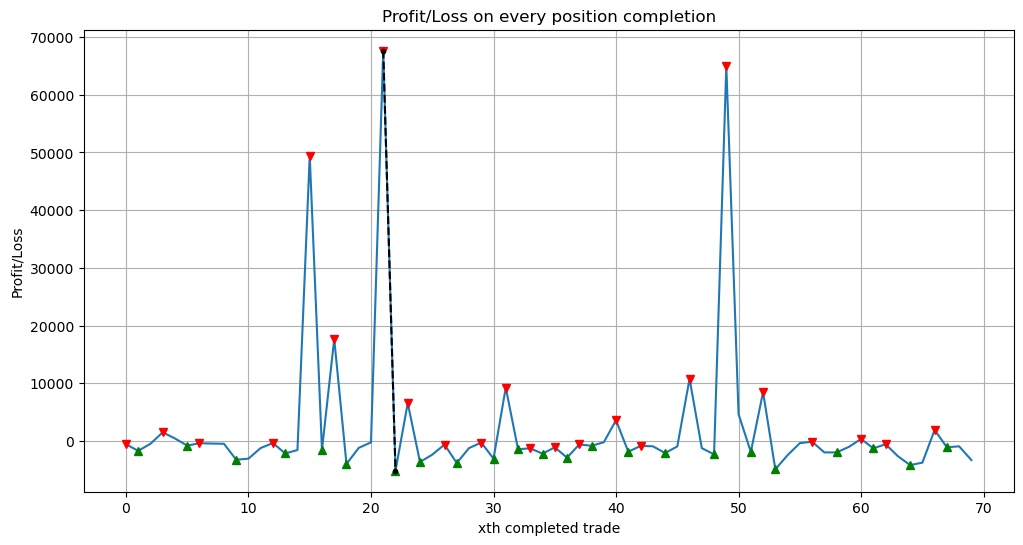

In [1786]:
plt.figure(figsize=(12,6))
plt.plot(profits)
for dd in dds:
    plt.plot(dd[1][0], dd[1][1], marker='v', color='r')
    plt.plot(dd[2][0], dd[2][1], marker='^', color='g')
plt.plot([max_dd[1][0], max_dd[2][0]], [max_dd[1][1], max_dd[2][1]], marker = '.', linestyle='--', color='black')
plt.grid(True)
plt.title("Profit/Loss on every position completion")
plt.xlabel("xth completed trade")
plt.ylabel("Profit/Loss")
plt.show()

In [1787]:
def plot_futures_and_ema(df, start_date, end_date):
    symbol = df['symbol'].iloc[0]
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    df = df.copy()
    df = df.loc[start:end]
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['close']/100, color='black')
    plt.plot(df.index, df['short']/100, color='green')
    plt.plot(df.index, df['long']/100, color='red')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(f'{symbol} Future Close Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price (in Rs)')
    plt.tight_layout() 
    plt.show()

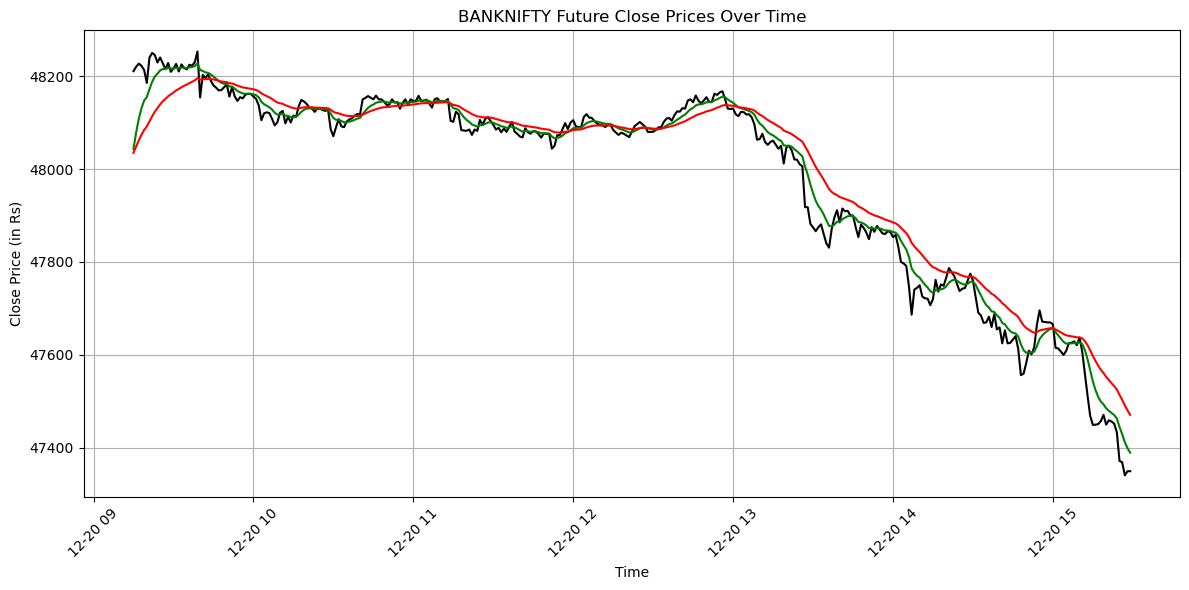

In [1788]:
plot_futures_and_ema(df_futures, '2023-12-20', '2023-12-21')

In [1789]:
def plot_options_and_trades(df_options, df_options_in_ram, opt_type, start_date, df_trades, filter_ticks):
    symbol = df_options['symbol'].iloc[0]
    
    start = pd.to_datetime(start_date)
    # end = pd.to_datetime(end_date)
    
    df_lala_options = df_options_in_ram[opt_type].copy()
    # df_lala_options = df_lala_options.loc[start:end]
    df_lala_options = df_lala_options[df_lala_options.index.date == start.date()]

    df_lala_trades = df_trades[df_trades['Call/Put'] == opt_type]
    # df_lala_trades = df_lala_trades.copy().loc[start:end]
    df_lala_trades = df_lala_trades[df_lala_trades.index.date == start.date()]

    strikes_traded = df_lala_trades['strike_price'].unique()
    num_strikes = len(strikes_traded)
    cols = 1
    rows = (num_strikes// cols) + (num_strikes % cols > 0)

    figure, axes = plt.subplots(rows, cols, figsize=(15, 5*rows), squeeze = False)
    axes = axes.flatten()
    
    for i, strike in enumerate(strikes_traded):
        ax = axes[i]
        ax.plot(df_lala_options.index, df_lala_options[strike]/100)
        trade_lines = df_lala_trades['strike_price'] == strike
        trade_lines = df_lala_trades[trade_lines]

        start_loop = int(trade_lines['Position'].iloc[0] == 0)
        for j in range(start_loop, len(trade_lines)-1, 2):
            ax.plot([trade_lines.index[j], trade_lines.index[j+1]], [trade_lines['Price'].iloc[j]/100, trade_lines['Price'].iloc[j+1]/100], color = 'green', marker="o")
            # ax.plot(trade_lines.index[j], trade_lines['Price'].iloc[j]/100, color = 'green', marker="o")
            # ax.plot(trade_lines.index[j+1], trade_lines['Price'].iloc[j+1]/100, color = 'green', marker="o")

        name = "Put"
        if opt_type:
            name = "Call"
        ax.set_title(f"{name} Options price and trades with strike = {strike}")
        ax.set_xlabel("time stamps")
        ax.set_ylabel("close prices in Rs")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
 
        # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(FuncFormatter(filter_ticks))
   
    for j in range(len(strikes_traded), len(axes)):
        figure.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

In [1790]:
def filter_ticks(x, pos=None):
    dt = mdates.num2date(x)
    if dt.hour < 9 or (dt.hour == 15 and dt.minute > 29) or dt.hour > 15:
        return ''
    return dt.strftime('%Y-%m-%d %H:%M')

In [1791]:
def plot_all_traded_options(df_options, df_ram, start, df_trades, filter_ticks):
    plot_options_and_trades(df_options, df_ram, 1, start, df_trades, filter_ticks)
    plot_options_and_trades(df_options, df_ram, 0, start, df_trades, filter_ticks)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


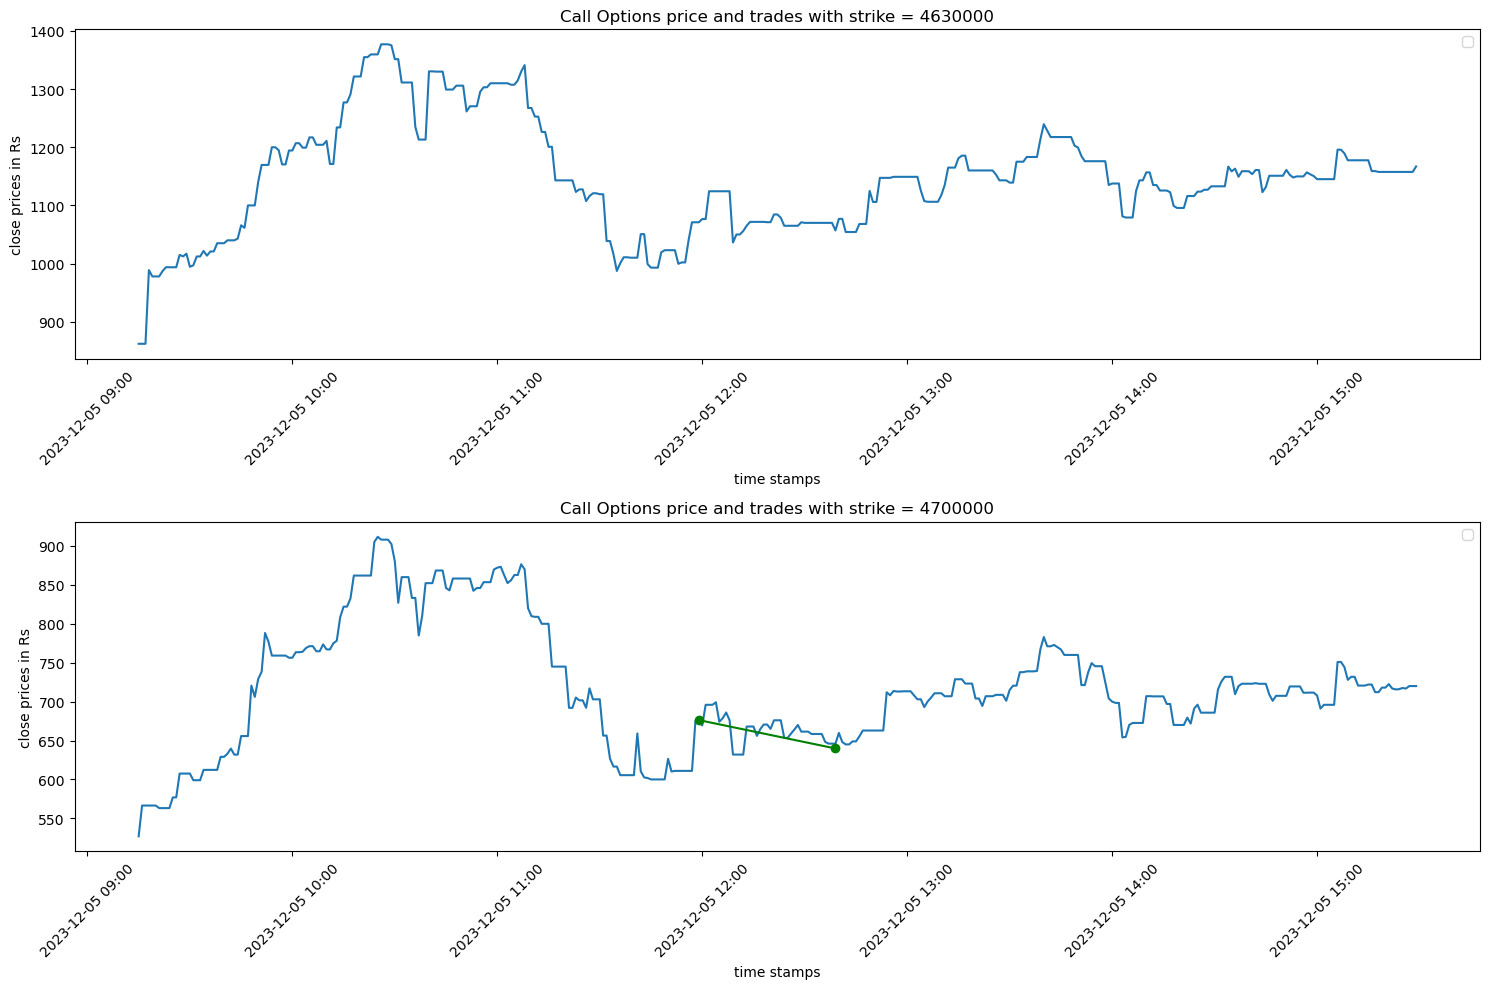

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


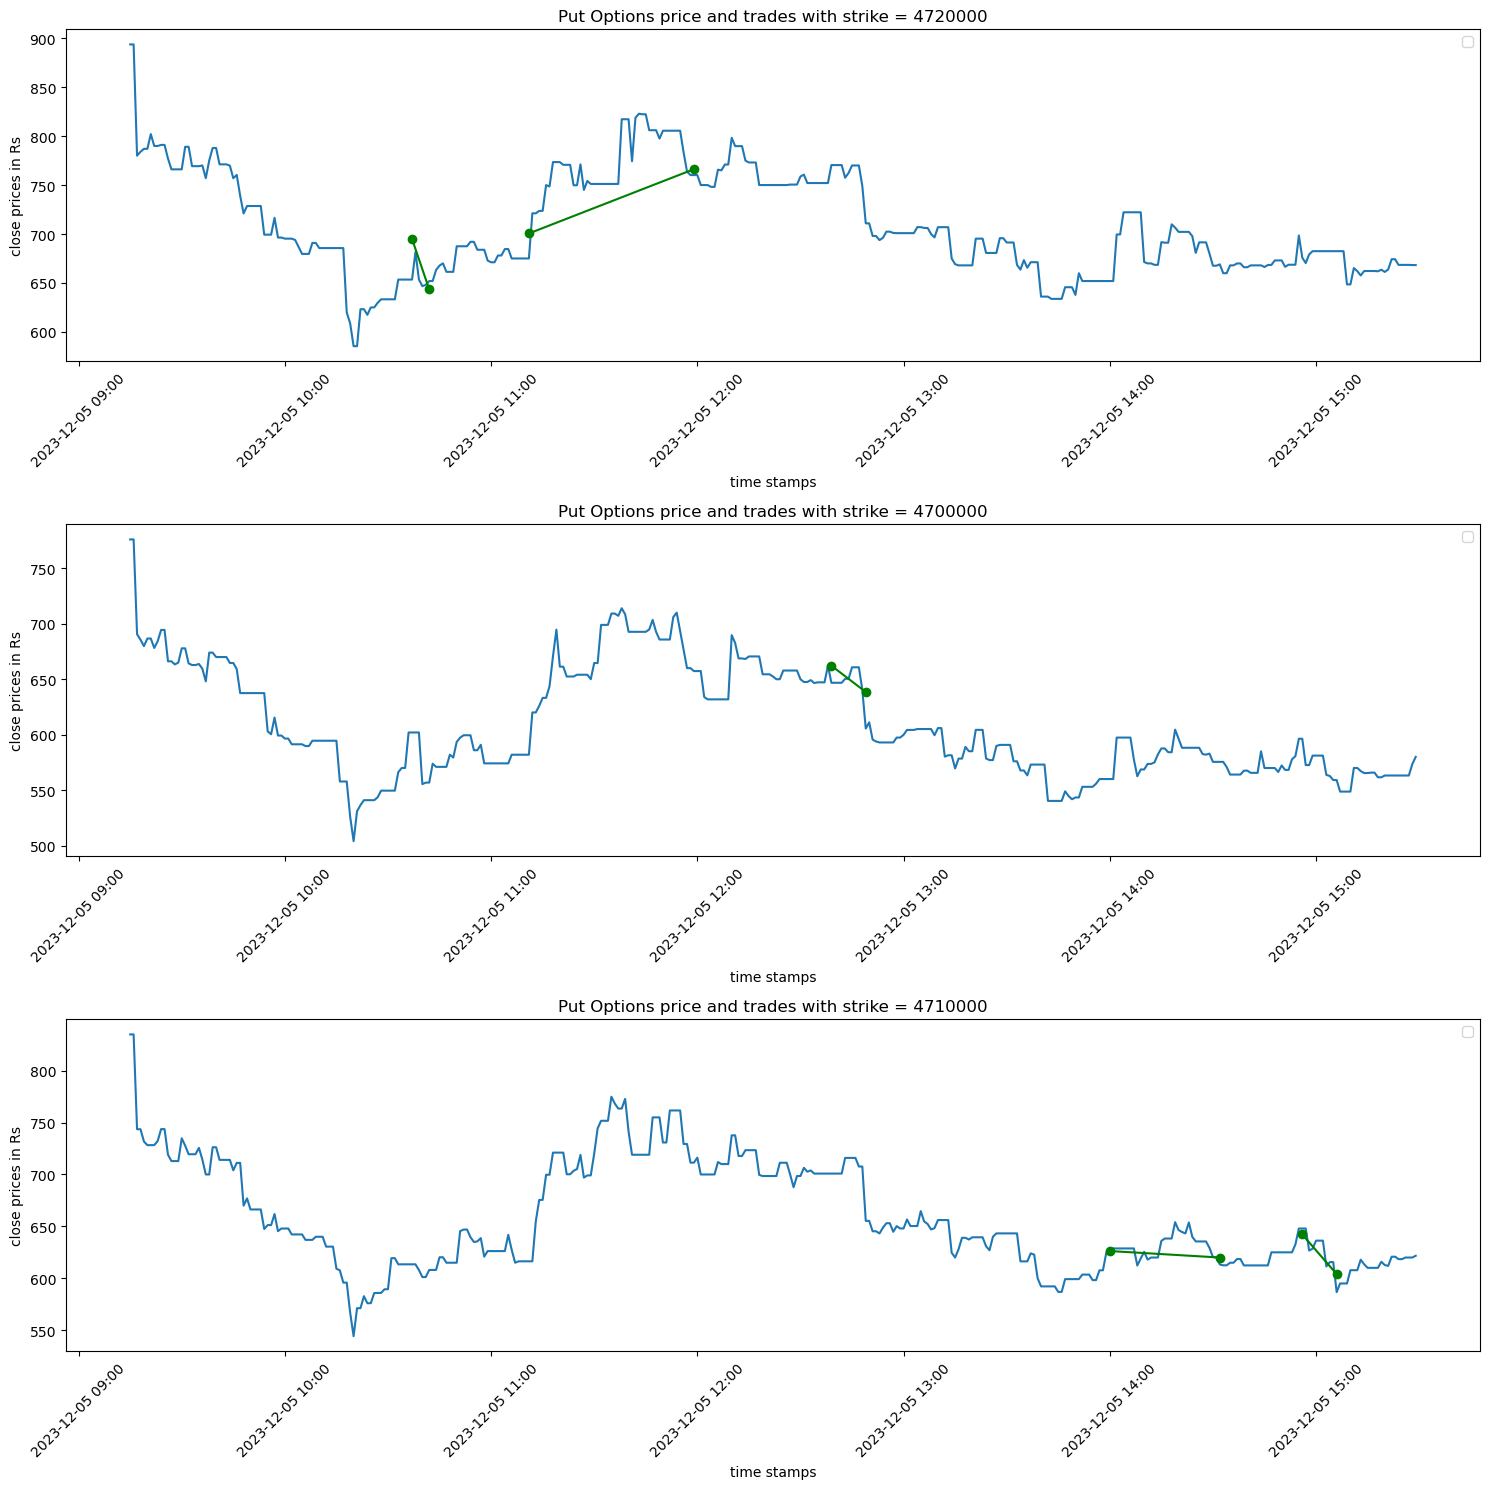

In [1792]:
plot_all_traded_options(df_options, df, '2023-12-05', df_trades, filter_ticks)

In [1793]:
class metrics:
    def __init__(self, df_trades, df_call_put_open, df_call_put_close, fund_locked, risk_free_rate=12, transaction_costs=11.5, slippage = 10):
        self.fund_locked = fund_locked
        self.risk_free_rate = risk_free_rate
        self.df_trades = df_trades
        self.df_call_put_close = df_call_put_close
        self.df_call_put_open = df_call_put_open
        self.transaction_costs = transaction_costs
        self.slippage = slippage

    def get_expense_cost(self, amount):
        transaction_costs = self.transaction_costs
        slippage = self.slippage
        return amount * (transaction_costs + slippage)* 1/100 * 1/100
        
    def number_of_trades(self):
        return self.df_trades.count().iloc[0]

    def PNL(self):
        df_trades = self.df_trades
        profit, net_profit, expenses = 0, 0, 0
        profits = []
        open_position = False
        for i, trade in df_trades.iterrows():
            price = trade['Price']
            position = trade['Position']
            cash_flow_nature = 1
            if position: # long -> pos = 1, short -> pos = 0
                cash_flow_nature = -1
            net_profit += cash_flow_nature * price
            profit += cash_flow_nature * price 
            expenses += self.get_expense_cost(price)
            if open_position and not position:
                profits.append(profit - expenses)
                profit, expenses = 0, 0
            open_position = position
        return net_profit, profits

    def net_turnover(self):
        prices = self.df_trades['Price']
        return prices.sum()
        
    def net_expenditure(self):
        # 1% = 100 basis points => total_turnover * 0.01/100 * total_basis_points
        turnover = self.net_turnover()
        return self.get_expense_cost(turnover)

    def net_return(self):
        net_profit, _ = self.PNL()
        return 100 * net_profit/ self.fund_locked

    def sharpe(self):
        profits_per_day = self.per_day_pnl()
        profits_per_day = pd.Series(profits_per_day)
        sharpe_ratio = profits_per_day.mean()
        sharpe_ratio -= self.fund_locked * self.risk_free_rate * 1/100 * 1/365
        sharpe_ratio /= profits_per_day.std()
        return sharpe_ratio

    def max_drawdown(self):
        _, profits = self.PNL()
        increments = [(profits[i] - profits[i - 1]) for i in range(1, len(profits))]
        dd = 0
        max_dd = 0
        for inc in increments:
            dd += inc
            dd = min(0, dd)
            max_dd = min(dd, max_dd)
        return max_dd
        
    def per_day_pnl(self):
        df_trades = self.df_trades
        df_call_put_close = self.df_call_put_close
        df_call_put_open = self.df_call_put_open
        trades_timestamps = df_trades.index.normalize().unique()
        print(trades_timestamps)
        pnl_per_day = []
        carry_over = False
        expense = 0
        for date in trades_timestamps:
            pnl_this_day = 0
            df_trades_this_day = df_trades[df_trades.index.normalize() == date]
            if carry_over:
                call_put = df_trades_this_day["Call/Put"].iloc[0]
                strike = df_trades_this_day["strike_price"].iloc[0]
                pnl_this_day = df_trades_this_day["Price"].iloc[0] - df_call_put_open[call_put][strike].loc[pd.Timestamp.combine(date, time(9, 15))]
                df_trades_this_day = df_trades_this_day.iloc[1:]
                carry_over = False
            df_prices = df_trades_this_day['Price']
            df_cashflow_nature = 1 * df_trades_this_day['Position'] + (-1) * (1 - df_trades_this_day['Position'])
            df_profits = df_prices * df_cashflow_nature
            df_expenses = self.get_expense_cost(df_prices)
            pnl_this_day += df_profits.sum() - df_expenses.sum()
            if df_trades_this_day['Position'].iloc[-1] == 1:
                call_put = df_trades_this_day['Call/Put'].iloc[-1]
                strike = df_trades_this_day['strike_price'].iloc[-1]
                date_timestamp = pd.Timestamp.combine(date, time(15, 29))
                pnl_this_day -= df_call_put_close[call_put][strike].loc[date_timestamp]
                carry_over = True
            pnl_per_day.append(pnl_this_day)
        return pnl_per_day

In [1794]:
# metrics = metrics(df_trades_test, profits_test, 100000, 12)
metrics = metrics(df_trades, df_call_put_open, df_call_put_close, fund_locked, 12, 11.5, 10)

In [1841]:
metrics.per_day_pnl()

DatetimeIndex(['2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-11', '2023-12-12',
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', name='date_timestamp', freq=None)


[12713.680000000008,
 -18117.507500000007,
 38543.39325,
 1003.7180000000001,
 -5501.42875,
 1055.196,
 1978.3995,
 3568.60125,
 -1057.4975,
 675.487,
 2652.75475,
 -9125.828,
 -51347.1355,
 15897.65625,
 -3850.63825,
 6385.5075,
 8862.0955,
 7011.2845]

In [1795]:
number_of_trades = metrics.number_of_trades()
sharpe = metrics.sharpe()
net_profit, _ = metrics.PNL()
net_expenditure = metrics.net_expenditure()
net_return = metrics.net_return()
max_drawdown = metrics.max_drawdown()

print("number of trades:", number_of_trades)
print("sharpe:", sharpe)
print("net profit:", f"₹{net_profit/100}")
print("net expenditure (transaction costs + slippage):", f"₹{net_expenditure/100}")
print("net return:", f"{net_return}%")
print("max drawdown in PNL:", f"₹{abs(max_drawdown)/100}")

DatetimeIndex(['2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-11', '2023-12-12',
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', name='date_timestamp', freq=None)
number of trades: 141
sharpe: 0.03422632651365777
net profit: ₹1503.0
net expenditure (transaction costs + slippage): ₹138.534175
net return: 150.3%
max drawdown in PNL: ₹726.9417575
